### OSF Audio Dataset Classifier with Machine Learning

Build a sound classifier using MFCC and machine learnig from OSF data.

In [1]:
%matplotlib inline
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.utils import multi_gpu_model
import numpy as np
import json
import PIL
import os
import librosa
import sklearn
import keras
from plot_keras_history import plot_history
from sklearn.utils import shuffle

np.random.seed(1)

# Prepare training, validation and test data


In [2]:
label_path_train = '/Users/xt/Desktop/OSF/audio/train'
label_path_validation = '/Users/xt/Desktop/OSF/audio/validation'
label_path_test = '/Users/xt/Desktop/OSF/audio/test'

def load_label(label_path):
    label = [f for f in os.listdir(label_path) if f != '.DS_Store']
    return label

In [3]:
# MFCC parameters
def wav2mfcc(path, max_pad_size=11):
    y, sr = librosa.load(path=path, sr=None, mono=False)
    y = y[::3]
    # default frame
    audio_mac = librosa.feature.mfcc(y=np.asfortranarray(y), sr=16000)
    y_shape = audio_mac.shape[1]
    if y_shape < max_pad_size:
        pad_size = max_pad_size - y_shape
        audio_mac = np.pad(audio_mac, ((0, 0), (0, pad_size)), mode='constant')
    else:
        audio_mac = audio_mac[:, :max_pad_size]
    return audio_mac

In [4]:
# Convert data to arrays
def data_to_array(label_path, max_pad_size=11):
    mfcc_vectors = []
    target = []
    labels = load_label(label_path=label_path)
    for i, label in enumerate(labels):
        path = label_path + '/' + label
        wavfiles = [path + '/' + file for file in os.listdir(path) if file != '.DS_Store']
        for wavfile in wavfiles:
            if wavfile != '.DS_Store':
                wav = wav2mfcc(wavfile, max_pad_size=max_pad_size)
                mfcc_vectors.append(wav)
                target.append(i)
    return np.array(mfcc_vectors), np.array(target)


In [5]:
# Get trainig/validation/testing data
x_train, y_train = data_to_array(label_path_train)
x_validation, y_validation = data_to_array(label_path_validation)
x_test, y_test = data_to_array(label_path_test)

x_train = x_train.reshape(-1, 220)
x_validation = x_validation.reshape(-1, 220)
x_test = x_test.reshape(-1, 220)
y_train_hot = keras.utils.to_categorical(y_train)
y_validation_hot = keras.utils.to_categorical(y_validation)
y_test_hot = keras.utils.to_categorical(y_test)

x_train, y_train_hot = shuffle(x_train, y_train_hot)

# Fine-tune the model

Epoch 1/50
59/59 - 0s - loss: 0.6620 - accuracy: 0.6141 - val_loss: 0.7035 - val_accuracy: 0.6292
Epoch 2/50
59/59 - 0s - loss: 0.6268 - accuracy: 0.6311 - val_loss: 0.6340 - val_accuracy: 0.6161
Epoch 3/50
59/59 - 0s - loss: 0.6025 - accuracy: 0.6472 - val_loss: 0.7449 - val_accuracy: 0.6243
Epoch 4/50
59/59 - 0s - loss: 0.5831 - accuracy: 0.6625 - val_loss: 0.6218 - val_accuracy: 0.6226
Epoch 5/50
59/59 - 0s - loss: 0.5715 - accuracy: 0.6843 - val_loss: 0.6576 - val_accuracy: 0.6464
Epoch 6/50
59/59 - 0s - loss: 0.5528 - accuracy: 0.6833 - val_loss: 0.7964 - val_accuracy: 0.6243
Epoch 7/50
59/59 - 0s - loss: 0.5419 - accuracy: 0.6959 - val_loss: 0.6529 - val_accuracy: 0.6637
Epoch 8/50
59/59 - 0s - loss: 0.5261 - accuracy: 0.6978 - val_loss: 0.6521 - val_accuracy: 0.6382
Epoch 9/50
59/59 - 0s - loss: 0.5110 - accuracy: 0.7153 - val_loss: 0.7772 - val_accuracy: 0.6087
Epoch 10/50
59/59 - 0s - loss: 0.4969 - accuracy: 0.7169 - val_loss: 0.7726 - val_accuracy: 0.6415
Epoch 11/50
59/59 -

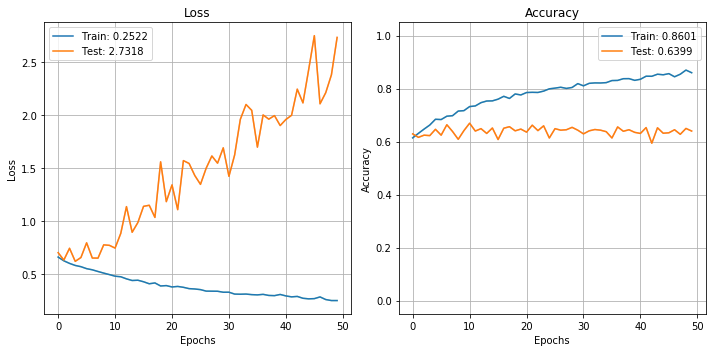

In [6]:
# Training a Neural Network for classification
from tensorflow.keras import initializers
model = Sequential()
model.add(Dense(64, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.02)))
model.add(Dense(64, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.02)))
model.add(Dense(32, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.02)))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.RMSprop(),metrics=['accuracy']) #
history = model.fit(x_train, y_train_hot, batch_size=64, epochs=50, verbose=2,validation_data=(x_validation, y_validation_hot)).history
plot_history(history)

# Calculate and plot confusion matrix

In [7]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)
    plt.figure(figsize=(24,24))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

Normalized confusion matrix


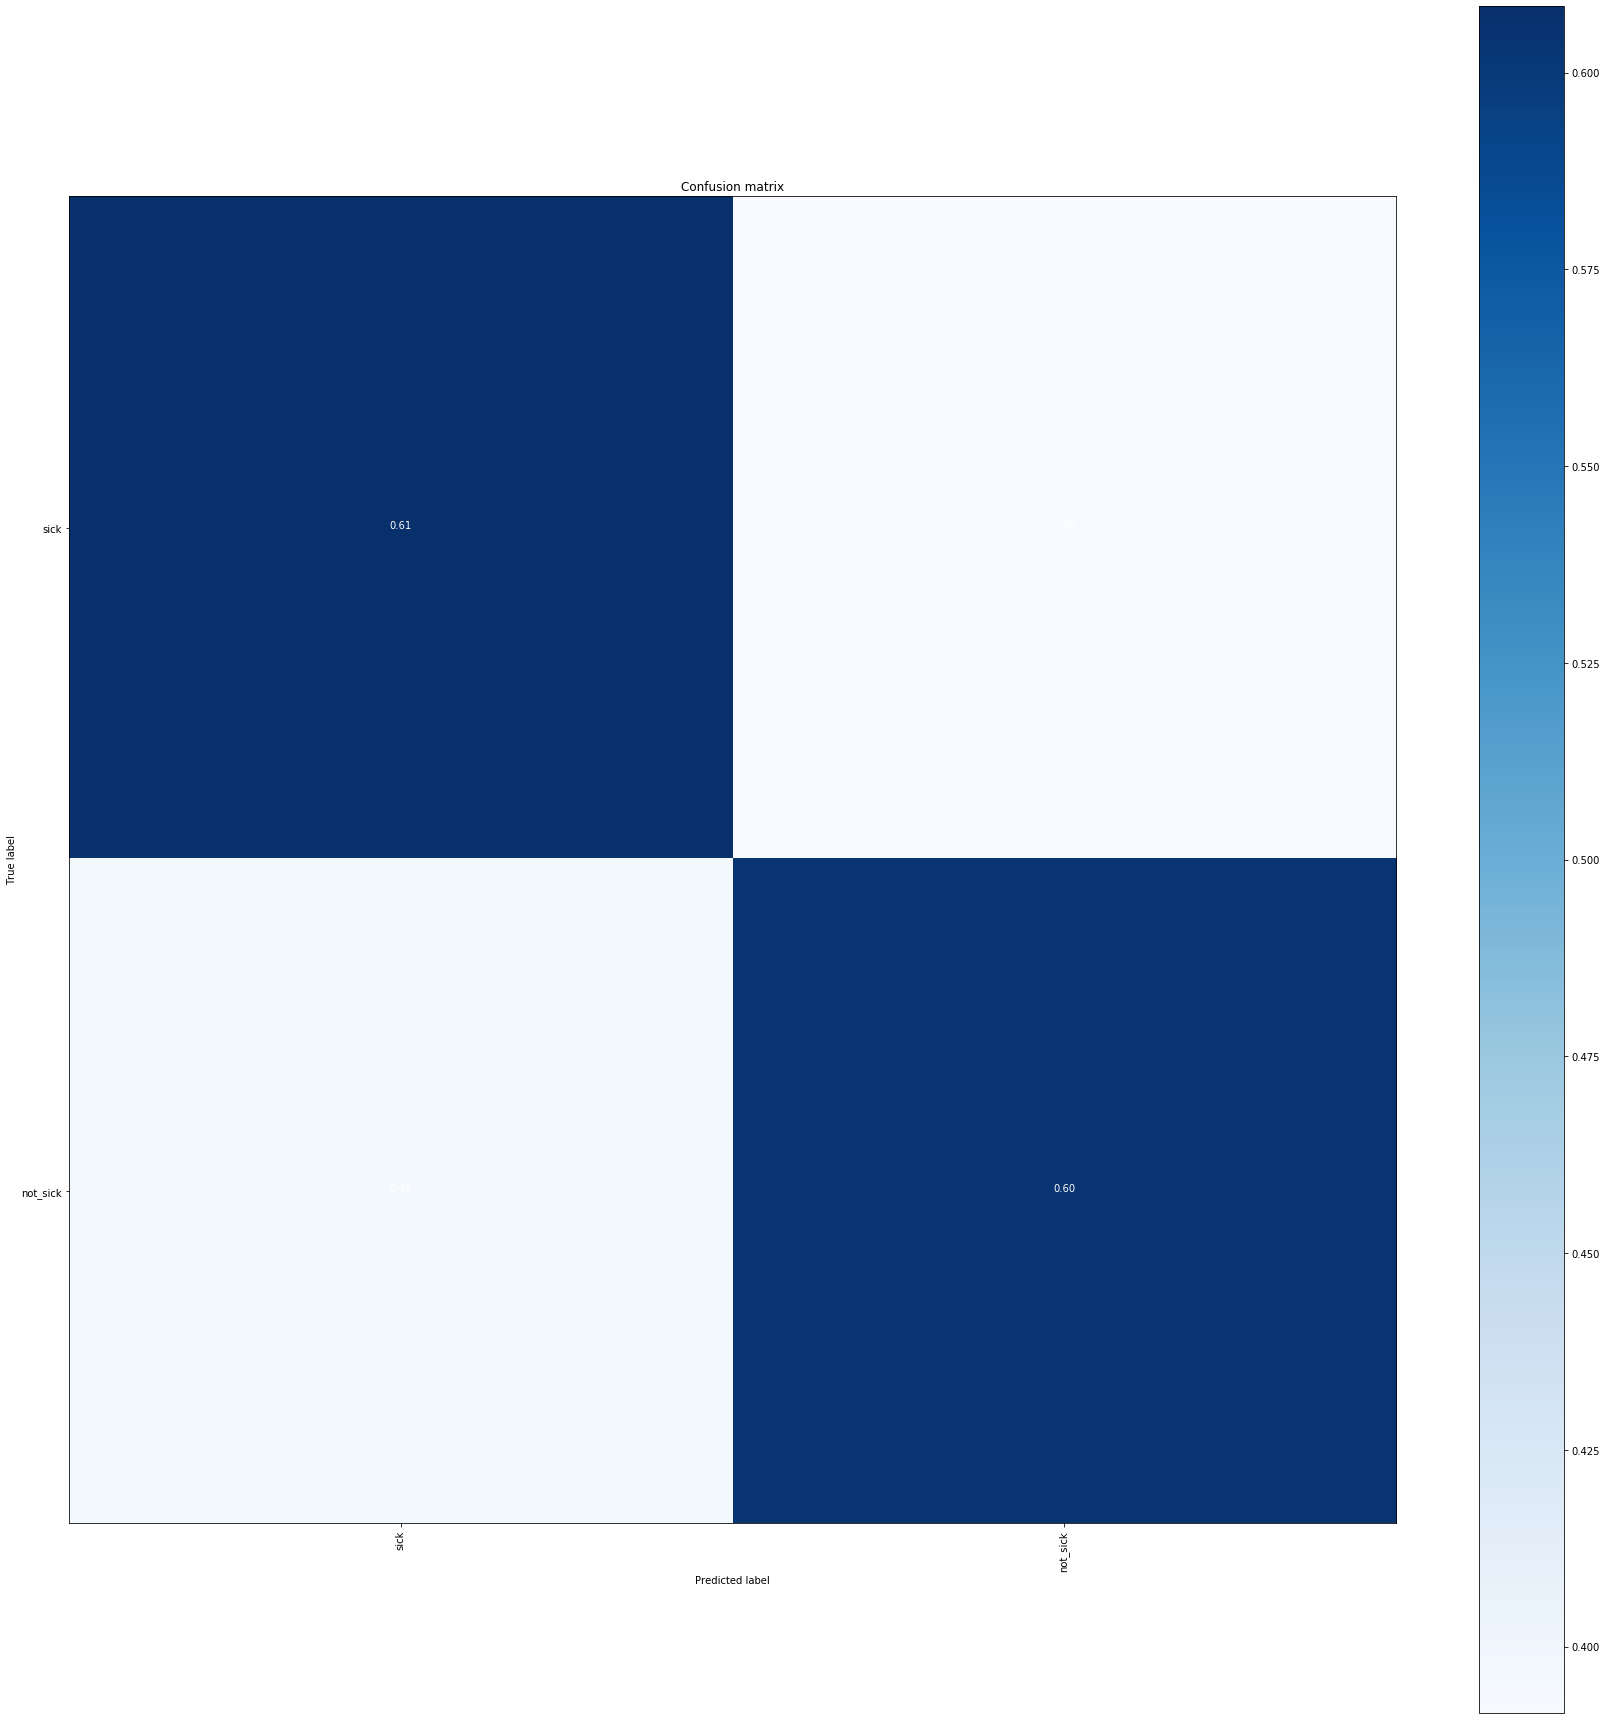

In [8]:
import os
import io
import requests
import urllib.request
from PIL import Image
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = np.argmax(model.predict(x_test), axis=1)

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, ['sick','not_sick'], normalize=True) #sorted(label_map.keys())